In [1]:
import pandas as pd
import numpy as np
from model_function import Load_Model

import warnings
warnings.filterwarnings("ignore")

X_train_df = pd.DataFrame(Load_Model("X_train"), columns = Load_Model("features"))
X_test_df = pd.DataFrame(Load_Model("X_test"), columns = Load_Model("features"))
X_test = Load_Model("X_test")
y_test = Load_Model("y_test")
#y_test_df = pd.DataFrame(y_test, columns = ['percent_houses_damaged'])
X_train = Load_Model("X_train")
y_train = Load_Model("y_train")
features = Load_Model("features")



A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [2]:
from model_function import predict2SGGlobal
y_trainxgb2 = predict2SGGlobal(X_train)
y_testxgb2 = predict2SGGlobal(X_test)

from model_function import TwoStageXGB

xgb2sg = TwoStageXGB()
xgb2sg.fit(X_train, y_train)
y_testxgb2 = xgb2sg.predict(X_test)
y_trainxgb2 = xgb2sg.predict(X_train)

# Linear Models

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from model_function import eval_bins
from featurelists import shap_list, lime_list, shap_list_xgb2, lime_list_xgb2

In [7]:

lr = LinearRegression()
lr.fit(X_train, y_trainxgb2)
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_testxgb2, y_pred)
print("MSE: ", mse)
#RSME

import numpy as np
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

eval_bins(y_testxgb2, y_pred, y_test)[0]

MSE:  10.775012835397131
RMSE:  3.2825314675410397
Bin: [0, 9e-05]      RMSE: 1.701, Avg. Error: -0.067
Bin: [9e-05, 1]      RMSE: 2.640, Avg. Error: -1.264
Bin: [1, 10]         RMSE: 4.687, Avg. Error: -0.626
Bin: [10, 50]        RMSE: 14.226, Avg. Error: 9.052
Bin: [50, 100]       RMSE: 29.940, Avg. Error: 25.448
Total RSME 3.2825314675410397
Total Avg. Error -0.02546298582427982


[[0, 9e-05],
 2.8918148944136415,
 1.7005337086966672,
 1.2180754978493418,
 -0.06659140607103134]

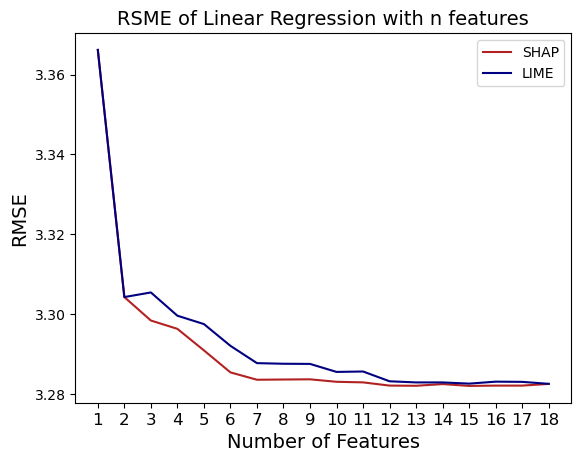

In [11]:
# LIME vs SHAP
rmse_list = []
for n in range(1, len(shap_list_xgb2)+1):
    lr = LinearRegression()
    lr.fit(X_train_df[shap_list_xgb2[:n]], y_trainxgb2)
    y_pred = lr.predict(X_test_df[shap_list_xgb2[:n]])
    mse = mean_squared_error(y_testxgb2, y_pred)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)

rmse_list2 = []
for n in range(1, len(lime_list_xgb2)+1):
    lr = LinearRegression()
    lr.fit(X_train_df[lime_list_xgb2[:n]], y_trainxgb2)
    y_pred = lr.predict(X_test_df[lime_list_xgb2[:n]])
    mse = mean_squared_error(y_testxgb2, y_pred)
    rmse = np.sqrt(mse)
    rmse_list2.append(rmse)

# plot
import matplotlib.pyplot as plt
plt.plot(rmse_list, color = 'firebrick', label = 'SHAP')
plt.plot(rmse_list2, color = 'navy', label = 'LIME')
plt.xlabel('Number of Features', fontsize = 14)
plt.xticks(range(len(shap_list)), list(range(1,19)), fontsize = 12)
plt.ylabel('RMSE', fontsize = 14)
plt.title('RSME of Linear Regression with n features', fontsize = 14)
plt.legend()
plt.show()

In [39]:
# only use best n variables
n = 3
lr = LinearRegression()
lr.fit(X_train_df[shap_list_xgb2[:n]], y_trainxgb2)
y_pred = lr.predict(X_test_df[shap_list_xgb2[:n]])

mse = mean_squared_error(y_testxgb2, y_pred)
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))

eval_bins(y_testxgb2, y_pred, y_test)[0]

# print out the coefficients as formula
i = lr.intercept_
c = lr.coef_
print(round(i,2), end = ' + ')
for j in range(n):
    if j == round(n/2):
        print()
    print(f"{c[j]:.2f} * {shap_list[j]} ", end = '+ ')

MSE:  11.16282620582954
RMSE:  3.341081592213746
Bin: [0, 9e-05]      RMSE: 1.689, Avg. Error: -0.042
Bin: [9e-05, 1]      RMSE: 2.731, Avg. Error: -1.387
Bin: [1, 10]         RMSE: 4.869, Avg. Error: -0.613
Bin: [10, 50]        RMSE: 14.745, Avg. Error: 9.442
Bin: [50, 100]       RMSE: 29.818, Avg. Error: 25.751
Total RSME 3.341081592213746
Total Avg. Error -0.015245267442513033
0.99 + 3.08 * wind_speed + 1.01 * track_distance + 
0.19 * rainfall_max_6h + 

## include powers of wind_speed

In [46]:
n = 18
pwr = 4
lr_Xtrain = X_train_df[shap_list_xgb2[:n]]
lr_Xtrain["ws_2"] = lr_Xtrain["wind_speed"]**pwr
lr_Xtest = X_test_df[shap_list_xgb2[:n]]
lr_Xtest["ws_2"] = lr_Xtest["wind_speed"]**pwr

lr = LinearRegression()
lr.fit(lr_Xtrain, y_trainxgb2)
y_pred = lr.predict(lr_Xtest)

mse = mean_squared_error(y_testxgb2, y_pred)
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))

eval_bins(y_testxgb2, y_pred, y_test)[0]

MSE:  2.9074396647489653
RMSE:  1.7051215982295707
Bin: [0, 9e-05]      RMSE: 0.728, Avg. Error: -0.047
Bin: [9e-05, 1]      RMSE: 1.532, Avg. Error: -0.278
Bin: [1, 10]         RMSE: 3.846, Avg. Error: -0.185
Bin: [10, 50]        RMSE: 7.671, Avg. Error: 2.239
Bin: [50, 100]       RMSE: 10.143, Avg. Error: 6.360
Total RSME 1.7051215982295707
Total Avg. Error -0.026865480878459823


[[0, 9e-05],
 0.529752763519438,
 0.7278411664088793,
 0.31440425734748473,
 -0.047419832166812365]

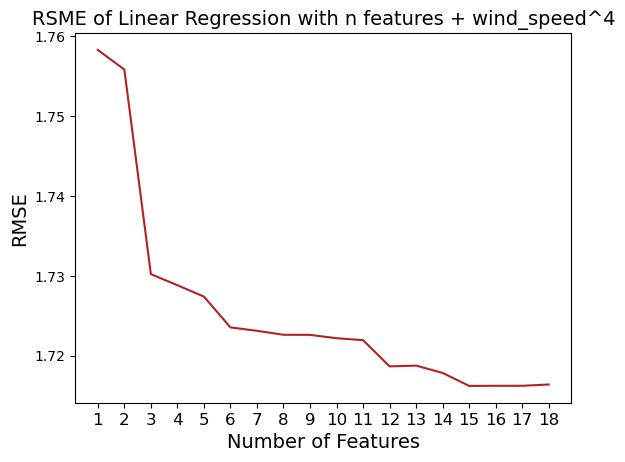

In [15]:
pwr = 4

rmse_list = []
for n in range(1, 19):
    # print("n: ", n) 
    lr_Xtrain = X_train_df[shap_list_xgb2[:n]]
    lr_Xtrain["ws_2"] = lr_Xtrain["wind_speed"]**pwr
    lr_Xtest = X_test_df[shap_list_xgb2[:n]]
    lr_Xtest["ws_2"] = lr_Xtest["wind_speed"]**pwr

    lr = LinearRegression()
    lr.fit(lr_Xtrain, y_trainxgb2)
    y_pred = lr.predict(lr_Xtest)

    mse = mean_squared_error(y_testxgb2, y_pred)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)

    # eval_bins(y_testxgb, y_pred, y_test)[0]


# plot
import matplotlib.pyplot as plt
plt.plot(rmse_list, color = 'firebrick', label = 'SHAP')
plt.xlabel('Number of Features', fontsize = 14)
plt.xticks(range(len(shap_list_xgb2)), list(range(1,19)), fontsize = 12)
plt.ylabel('RMSE', fontsize = 14)
plt.title('RSME of Linear Regression with n features + wind_speed^4', fontsize = 14)
#plt.legend()
plt.show()

Text(0.5, 1.0, 'Linear Regression with n features + power of wind_speed')

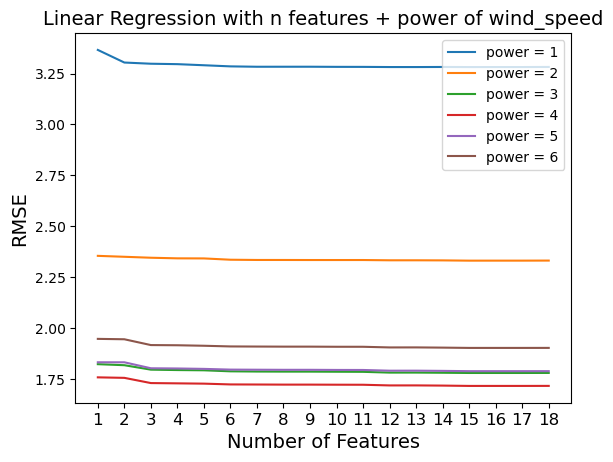

In [16]:
# only use best n variables

def pwr_rmse(pwr):
    rmse_list = []
    for n in range(1, 19):
        # print("n: ", n) 
        lr_Xtrain = X_train_df[shap_list_xgb2[:n]]
        lr_Xtrain["ws_2"] = lr_Xtrain["wind_speed"]**pwr
        lr_Xtest = X_test_df[shap_list_xgb2[:n]]
        lr_Xtest["ws_2"] = lr_Xtest["wind_speed"]**pwr

        lr = LinearRegression()
        lr.fit(lr_Xtrain, y_trainxgb2)
        y_pred = lr.predict(lr_Xtest)

        mse = mean_squared_error(y_testxgb2, y_pred)
        rmse = np.sqrt(mse)
        rmse_list.append(rmse)
    return rmse_list

# plt.plot(pwr_rmse(4), label = f"power = 4")
plt.xticks(range(len(shap_list)), list(range(1,19)), fontsize = 12)

# plot for different power
pwr_list = [1,2,3,4,5,6]	
rmse_list = []
for pwr in pwr_list:
    plt.plot(pwr_rmse(pwr), label = f"power = {pwr}")
plt.xticks(range(len(shap_list)), list(range(1,19)), fontsize = 12)
plt.xlabel('Number of Features', fontsize = 14)
plt.legend(loc = 'upper right')
plt.ylabel('RMSE', fontsize = 14)
plt.title('Linear Regression with n features + power of wind_speed', fontsize = 14)

In [17]:
# only use best n variables
n = 3
pwr = 4

lr = LinearRegression()

lr_Xtrain = X_train_df[shap_list_xgb2[:n]]
lr_Xtrain["ws_2"] = lr_Xtrain["wind_speed"]**pwr
lr_Xtest = X_test_df[shap_list_xgb2[:n]]
lr_Xtest["ws_2"] = lr_Xtest["wind_speed"]**pwr

lr = LinearRegression()
lr.fit(lr_Xtrain, y_trainxgb2)
y_pred = lr.predict(lr_Xtest)

mse = mean_squared_error(y_testxgb2, y_pred)
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))

eval_bins(y_testxgb2, y_pred, y_test)[0]

# print out the coefficients as formula
i = lr.intercept_
c = lr.coef_
print(round(i,2), end = '\n')
for j in range(n+1):
    if j == n:
        print(f"{c[j]:.2f} * wind_speed^{pwr}", end = '\n')
    else:
        print(f"{c[j]:.2f} * {shap_list[j]}", end = '\n')

MSE:  2.9936697608073004
RMSE:  1.7302224599187528
Bin: [0, 9e-05]      RMSE: 0.716, Avg. Error: -0.030
Bin: [9e-05, 1]      RMSE: 1.557, Avg. Error: -0.330
Bin: [1, 10]         RMSE: 3.941, Avg. Error: -0.168
Bin: [10, 50]        RMSE: 7.892, Avg. Error: 2.009
Bin: [50, 100]       RMSE: 9.902, Avg. Error: 6.237
Total RSME 1.7302224599187528
Total Avg. Error -0.024616605313428488
0.17
0.13 * wind_speed
-0.08 * track_distance
0.30 * rainfall_max_6h
0.19 * wind_speed^4


windspeed positive coefficient, compared to negative in simple XGB
simple XGB 
pred =  0.03
            -0.13 * wind_speed
            -0.12 * track_distance
            0.23 * rainfall_max_6h
            0.19 * wind_speed^4


## GLM

In [19]:
train_df = Load_Model("X_train")
train_df["xgb_pred"] = np.array(y_trainxgb2)
train_df

,wind_speed,track_distance,total_houses,rainfall_max_6h,rainfall_max_24h,rwi,mean_slope,std_slope,mean_tri,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,xgb_pred
0,-0.856555,1.171554,1.135117,-0.622338,-0.614954,1.812785,-1.253141,-1.761114,-1.230703,-1.630404,-0.736261,1.419780,0.935205,2.616238,-0.995806,-0.532048,0.976106,-0.240661,0.004505
1,-0.721854,1.615811,-0.266746,-0.775814,-0.955256,0.092268,-0.511528,-0.355795,-0.415348,-0.231075,-0.667434,1.360675,0.935205,-0.731012,-1.348081,1.783850,-0.273998,-0.241398,0.065325
2,-0.707059,1.334032,-0.251563,-1.082427,-1.104843,0.184509,-0.841787,-1.132003,-0.812952,-1.061138,-0.695688,0.269003,0.935205,-0.731012,-1.429376,1.865587,-0.262936,-0.241398,0.045594
3,2.279204,-1.611215,2.719272,0.107935,0.628674,3.700699,-0.886581,0.055877,-0.924670,0.161881,-0.583968,0.649223,0.935205,1.872405,-1.293885,0.203590,2.745908,-0.128161,3.013477
4,-0.640732,-0.426439,0.013277,-0.354515,-0.217106,0.445665,-0.101521,0.727710,-0.090182,0.772969,-0.011754,-0.657215,-1.069284,-0.266117,0.928162,-0.777261,-0.147534,-0.241248,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39798,2.663132,-1.609933,-0.209554,0.479312,0.817730,-1.200221,0.179528,0.368906,0.206790,0.261839,-0.186781,-0.657215,-1.069284,-0.591544,1.117849,-0.777261,-0.220732,-0.088301,6.100111
39799,1.424884,-0.833592,-0.168857,-0.244553,0.146413,0.211687,-1.088423,-1.271972,-1.126675,-1.271957,-0.704177,0.546400,0.935205,-0.033669,-1.348081,1.375162,-0.146397,-0.145803,1.261724
39800,-0.404339,0.609623,-0.270483,-0.972802,-0.959236,-0.642774,0.462960,1.558501,0.522721,1.727882,-0.338993,-0.046705,0.935205,-0.731012,-1.050002,1.484145,-0.279054,0.142771,0.018704
39801,-0.441242,1.275424,-0.175807,-0.580512,-0.327223,-1.067426,-1.031316,-1.171678,-1.053768,-1.151963,-0.650142,-0.389708,0.935205,-0.731012,1.199144,-0.777261,-0.183397,-0.173143,0.000000


In [22]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# all features
formula = ' + '.join(shap_list)

glm1 = smf.glm(formula = "xgb_pred ~ "+formula, 
                data = train_df, 
                family = sm.families.Poisson())

# Fit the model
result = glm1.fit()
# Display results
print(result.summary())
predictions = result.predict(X_test)

mse = mean_squared_error(y_testxgb2, predictions)
print("RMSE: ", np.sqrt(mse))
eval_bins(y_testxgb2, predictions, y_test)[0]

                 Generalized Linear Model Regression Results                  
Dep. Variable:               xgb_pred   No. Observations:                39803
Model:                            GLM   Df Residuals:                    39785
Model Family:                 Poisson   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26593.
Date:                Wed, 19 Jun 2024   Deviance:                       23577.
Time:                        14:31:34   Pearson chi2:                 1.45e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9805
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

[[0, 9e-05],
 0.4369068985090277,
 0.6609893331280223,
 0.15667870661046415,
 -0.04863738523913413]

Text(0.5, 1.0, 'RMSE vs Number of Features')

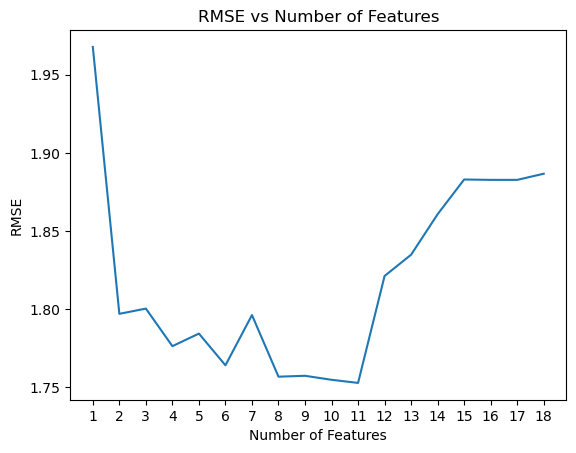

In [23]:
# GLM with different number of features
rmse_list = []
for n in range(1, len(shap_list_xgb2)+1):
    formula = ' + '.join(shap_list_xgb2[:n])
    GLM_model = smf.glm(formula = "xgb_pred ~ "+formula, 
                data = train_df, 
                family = sm.families.Poisson())
    # Fit the model
    result = GLM_model.fit()
    predictions = result.predict(X_test)
    mse = mean_squared_error(y_testxgb2, predictions)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)

#plot
import matplotlib.pyplot as plt
plt.plot(rmse_list)
plt.xlabel('Number of Features')
plt.xticks(range(len(shap_list_xgb2)), list(range(1,19)))
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Features')

In [25]:
shap_list_xgb2[:4]

['wind_speed',
 'track_distance',
 'rainfall_max_6h',
 'percent_houses_damaged_5years']

In [27]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

formula = ' + '.join(shap_list)

# 2 best features
model = smf.glm(formula = "xgb_pred ~ wind_speed + track_distance + rainfall_max_6h + percent_houses_damaged_5years",# + rainfall_max_6h",  #~
                data = train_df, 
                family = sm.families.Poisson())

# Fit the model
result = model.fit()
print(result.summary())
predictions = result.predict(X_test)

mse = mean_squared_error(y_testxgb2, predictions)
print("RMSE: ", np.sqrt(mse))
eval_bins(y_testxgb2, predictions, y_test)[0]

                 Generalized Linear Model Regression Results                  
Dep. Variable:               xgb_pred   No. Observations:                39803
Model:                            GLM   Df Residuals:                    39798
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27669.
Date:                Wed, 19 Jun 2024   Deviance:                       25730.
Time:                        14:36:36   Pearson chi2:                 1.57e+05
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9794
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

[[0, 9e-05],
 0.4838683765861665,
 0.6956064811272006,
 0.16754266743100812,
 -0.045533651655527446]

In [28]:
# add wind_speed^4

import statsmodels.formula.api as smf
import statsmodels.api as sm

model = smf.glm(formula = "xgb_pred ~  wind_speed + I(wind_speed**4)+  track_distance",# + rainfall_max_6h"
                data = train_df, 
                family = sm.families.Poisson())

# Fit the model
result = model.fit()
# Display and interpret results
print(result.summary())
# Estimated default probabilities
predictions = result.predict(X_test)

eval_bins(y_testxgb2, predictions, y_test)[0]

                 Generalized Linear Model Regression Results                  
Dep. Variable:               xgb_pred   No. Observations:                39803
Model:                            GLM   Df Residuals:                    39799
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28860.
Date:                Wed, 19 Jun 2024   Deviance:                       28112.
Time:                        14:37:33   Pearson chi2:                 2.01e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9781
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.2007      0

[[0, 9e-05],
 0.5023100762503876,
 0.7087383693933803,
 0.18032472557637816,
 -0.05191097804307608]

Text(0.5, 1.0, 'RMSE vs Number of Features')

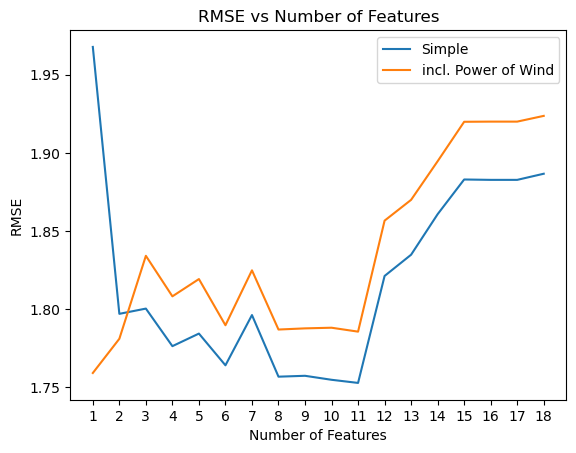

In [29]:
# GLM with different number of features
rmse_list_simple = []
rmse_list_pwr = []

for n in range(1, len(shap_list_xgb2)+1):

    formula = ' + '.join(shap_list_xgb2[:n])
    GLM_model = smf.glm(formula = "xgb_pred ~ "+formula, 
                data = train_df, 
                family = sm.families.Poisson())
    # Fit the model
    result = GLM_model.fit()

    predictions = result.predict(X_test)
    mse = mean_squared_error(y_testxgb2, predictions)
    rmse = np.sqrt(mse)
    rmse_list_simple.append(rmse)

    # add wind_speed^4
    formula = formula + ' + I(wind_speed**4)'
    GLM_model = smf.glm(formula = "xgb_pred ~ "+formula, 
                data = train_df, 
                family = sm.families.Poisson())
    # Fit the model
    result = GLM_model.fit()
    # Display and interpret results
    #print(result.summary())
    # Estimated default probabilities
    predictions = result.predict(X_test)
    mse = mean_squared_error(y_testxgb2, predictions)
    rmse = np.sqrt(mse)
    rmse_list_pwr.append(rmse)


#plot
import matplotlib.pyplot as plt
plt.plot(rmse_list_simple, label = 'Simple')
plt.plot(rmse_list_pwr, label = 'incl. Power of Wind')
plt.legend()
plt.xlabel('Number of Features')
plt.xticks(range(len(shap_list)), list(range(1,19)))
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Features')

In [30]:
# only wind_speed and wind_speed^4

import statsmodels.formula.api as smf
import statsmodels.api as sm

model = smf.glm(formula = "xgb_pred ~  wind_speed + I(wind_speed**4)",# + rainfall_max_6h"
                data = train_df, 
                family = sm.families.Poisson())

# Fit the model
result = model.fit()
# Display and interpret results
print(result.summary())
# Estimated default probabilities
predictions = result.predict(X_test)

eval_bins(y_testxgb2, predictions, y_test)[0]

                 Generalized Linear Model Regression Results                  
Dep. Variable:               xgb_pred   No. Observations:                39803
Model:                            GLM   Df Residuals:                    39800
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -29757.
Date:                Wed, 19 Jun 2024   Deviance:                       29904.
Time:                        14:40:25   Pearson chi2:                 1.77e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9771
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.9034      0

[[0, 9e-05],
 0.5044047545957162,
 0.7102145834856647,
 0.19117261130105995,
 -0.05294178544197206]

# Decision Trees

In [34]:
# decision tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X_train, y_trainxgb2)
y_pred = dt.predict(X_test)
mse = mean_squared_error(y_testxgb2, y_pred)
print("MSE: ", mse)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

# smaller improvement to linear regression compared to simple model

MSE:  3.2074565822762064
RMSE:  1.7909373473899657


In [32]:
# include power of wind_speed

from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=4)

# add wind_speed^4
dt_Xtrain = X_train_df.copy()#[shap_list[:n]]
dt_Xtrain["ws_2"] = dt_Xtrain["wind_speed"]**pwr
dt_Xtest = X_test_df.copy()#[shap_list[:n]]
dt_Xtest["ws_2"] = dt_Xtest["wind_speed"]**pwr

dt.fit(dt_Xtrain, y_trainxgb2)
y_pred = dt.predict(dt_Xtest)
mse = mean_squared_error(y_testxgb2, y_pred)
print("MSE: ", mse)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

# no improvement by adding power of wind_speed!

MSE:  2.728544705205481
RMSE:  1.651830713240761


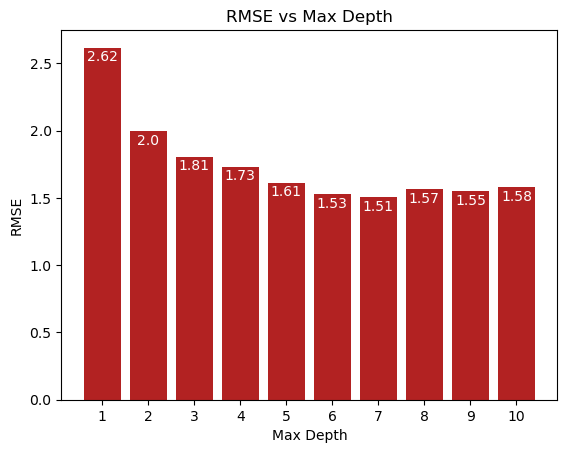

In [44]:
# RSME for different max_depth
rmse_list = []
for n in range(1, 11):
    dt = DecisionTreeRegressor(max_depth=n)
    dt.fit(X_train, y_trainxgb2)
    y_pred = dt.predict(X_test)
    mse = mean_squared_error(y_testxgb2, y_pred)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)

# plot
import matplotlib.pyplot as plt
# bar plot
plt.bar(range(10), rmse_list, color = 'firebrick')
plt.xlabel('Max Depth')
plt.xticks(range(10), list(range(1,11)))
plt.ylabel('RMSE')
plt.title('RMSE vs Max Depth')
# labels with values inside the bars
for i, v in enumerate(rmse_list):
    plt.text(i, v - 0.1, round(v,2), color='white', ha='center')
plt.show()

MSE:  3.002948040757602
RMSE:  1.7329016246624047
Bin: [0, 9e-05]      RMSE: 0.746, Avg. Error: -0.076
Bin: [9e-05, 1]      RMSE: 1.478, Avg. Error: -0.154
Bin: [1, 10]         RMSE: 4.018, Avg. Error: 0.115
Bin: [10, 50]        RMSE: 7.944, Avg. Error: 1.266
Bin: [50, 100]       RMSE: 9.250, Avg. Error: 3.244
Total RSME 1.7329016246624047
Total Avg. Error -0.042618713061866306


[Text(0.5, 0.9, 'wind_speed <= 2.917\nsquared_error = 18.968\nsamples = 39803\nvalue = 0.983'),
 Text(0.25, 0.7, 'wind_speed <= 1.971\nsquared_error = 5.219\nsamples = 39321\nvalue = 0.616'),
 Text(0.125, 0.5, 'wind_speed <= 1.375\nsquared_error = 1.955\nsamples = 37516\nvalue = 0.315'),
 Text(0.0625, 0.3, 'track_distance <= -0.933\nsquared_error = 0.874\nsamples = 35181\nvalue = 0.168'),
 Text(0.03125, 0.1, 'squared_error = 4.311\nsamples = 4984\nvalue = 0.737'),
 Text(0.09375, 0.1, 'squared_error = 0.244\nsamples = 30197\nvalue = 0.074'),
 Text(0.1875, 0.3, 'rwi <= -2.285\nsquared_error = 13.018\nsamples = 2335\nvalue = 2.53'),
 Text(0.15625, 0.1, 'squared_error = 838.576\nsamples = 2\nvalue = 43.74'),
 Text(0.21875, 0.1, 'squared_error = 10.853\nsamples = 2333\nvalue = 2.494'),
 Text(0.375, 0.5, 'wind_speed <= 2.494\nsquared_error = 32.072\nsamples = 1805\nvalue = 6.869'),
 Text(0.3125, 0.3, 'rainfall_max_6h <= 0.702\nsquared_error = 19.708\nsamples = 1186\nvalue = 5.13'),
 Text(0.2

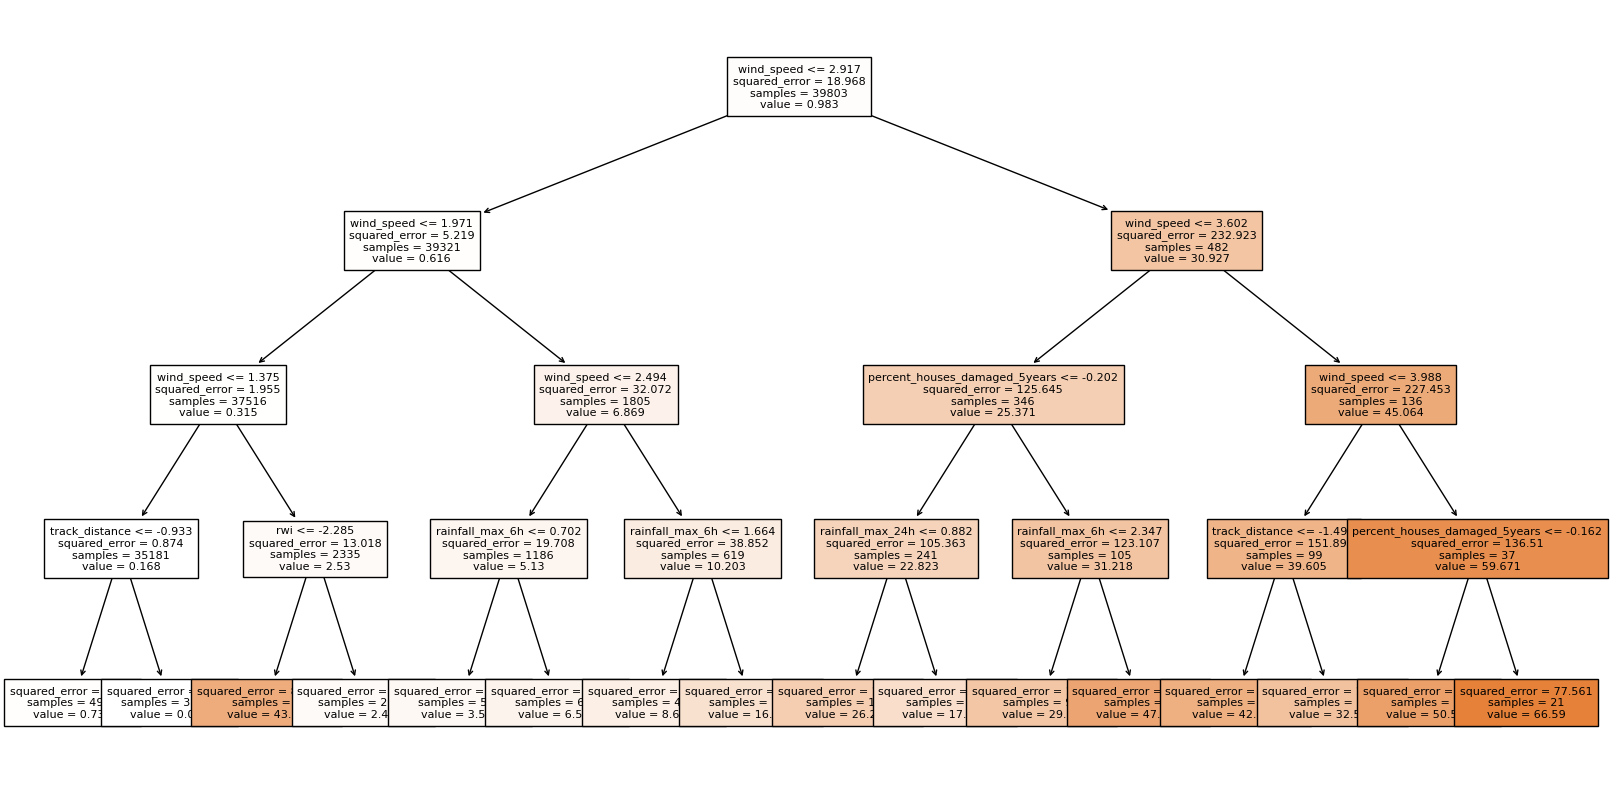

In [45]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor


dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_trainxgb2)
y_pred = dt.predict(X_test)
mse = mean_squared_error(y_testxgb2, y_pred)
print("MSE: ", mse)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

eval_bins(y_testxgb2, y_pred, y_test)[0]	

plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=features, filled=True, fontsize=8)

# Model based trees

In [58]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class XGB2STWrapper(BaseEstimator, RegressorMixin):
    def __init__(self):
        """
        Initialize the custom XGB2ST model wrapper.

        Parameters:
        **kwargs: All parameters required to initialize xgb2st model.
        """
        self.model = None

    def fit(self, X, y):
        """
        Fit the custom XGB2ST model.

        Parameters:
        X: array-like, shape (n_samples, n_features)
           Training data
        y: array-like, shape (n_samples,)
           Target values

        Returns:
        self: object
            Returns self.
        """
        # Initialize the xgb2st model with provided parameters
        self.model = TwoStageXGB()
        
        # Fit the model
        self.model.fit(X, y)
        self.dummy_ = "dummy"
        return self

    def predict(self, X):
        """
        Predict using the custom XGB2ST model.

        Parameters:
        X: array-like, shape (n_samples, n_features)
           Samples.

        Returns:
        y_pred: array, shape (n_samples,)
            Returns predicted values.
        """
        if self.model is None:
            raise ValueError("Model is not fitted yet!")
        
        # Predict using the fitted model
        return self.model.predict(X)

    def score(self, X, y):
        """
        Returns the R^2 score of the prediction.

        Parameters:
        X: array-like, shape (n_samples, n_features)
           Test samples.
        y: array-like, shape (n_samples,)
           True values for X.

        Returns:
        score: float
            R^2 score of self.predict(X) wrt. y.
        """
        from sklearn.metrics import r2_score
        
        y_pred = self.predict(X)
        return r2_score(y, y_pred)


In [59]:
xgb2sg = TwoStageXGB()
# xgb2sg.fit(X_train, y_train)
# y_testxgb2 = xgb2sg.predict(X_test)
# y_trainxgb2 = xgb2sg.predict(X_train)

w = XGB2STWrapper()
w.fit(X= X_train, y= y_train)

XGB2STWrapper()

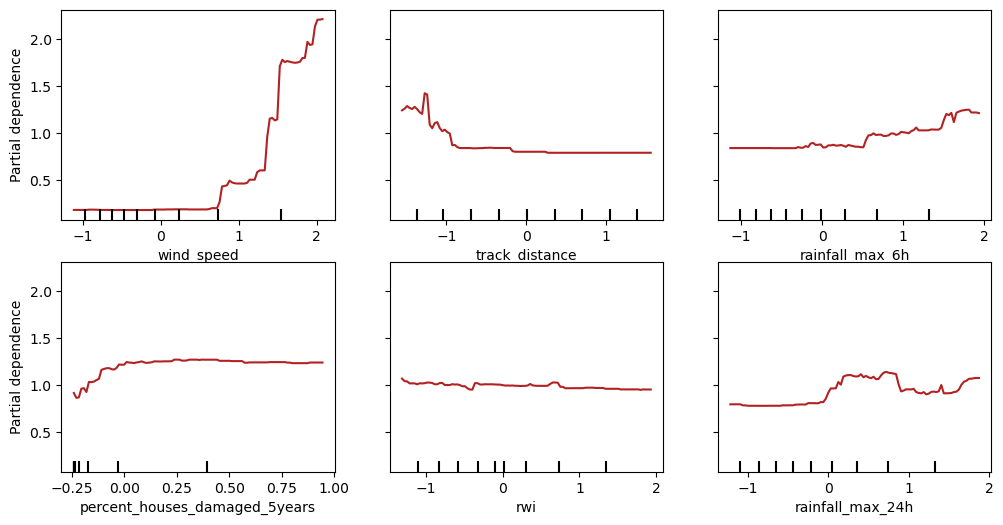

In [60]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence


xgb2sg.fit(X_train, y_train)
# xgb2sg.dummy_ ="dummy"
X_train_df = pd.DataFrame(Load_Model("X_train"), columns = Load_Model("features"))

fig, ax = plt.subplots(figsize=(12, 6))
# show grid
ax.grid(True)
display = PartialDependenceDisplay.from_estimator( w, X_train_df, ["wind_speed", "track_distance", "rainfall_max_6h", "percent_houses_damaged_5years", "rwi", "rainfall_max_24h"], ax=ax, line_kw={"color": "firebrick"})
#plt.show()

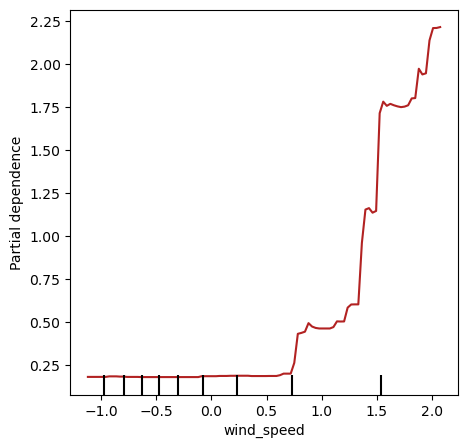

In [61]:
fig, ax = plt.subplots(figsize=(5, 5))
# show grid
ax.grid(True)
display = PartialDependenceDisplay.from_estimator( w, X_train_df, ["wind_speed"], ax=ax, line_kw={"color": "firebrick"})


## Functions

In [4]:
def predfunctiontree(X, models, conditions, n= 18, featlist = None):
    if featlist is None:
        featlist = X.columns
    fullprediction = []
    for index, row in X.iterrows():
        i = pd.DataFrame(row).transpose()
        i = i[featlist[:n]]
        case = matchfunction(row, conditions)
        predi = models[case].predict(i)[0][0]
        fullprediction.append(predi)
    return fullprediction

def matchfunction(x, condition):
    for f, cond in zip(condition.keys(), condition.values()):
        case = f
        for c in cond.keys():
            if x[c] > cond[c]:
                case = None
                break
        if case is not None:
            return case
    raise ValueError("No case found")

def buildfunctions(X, y, conditions, n = 18, featlist = None):
    if featlist is None:
        featlist = X.columns
    y = pd.DataFrame(y)
    y = y.reset_index(drop = True)
    models = {}

    X = X[featlist[:n]]

    unassigned = X.index
    for g, cond in zip(conditions.keys(), conditions.values()):
        idx = unassigned
        for c in cond.keys():
            # collect indexes of all conditions and take intersection
            idx_cond = X.loc[X[c] < cond[c]].index
            idx = idx_cond.intersection(idx)
        unassigned = unassigned.difference(idx) #update unassigned indices
        X_group = X.loc[idx]
        y_group = y.loc[idx]

        lr = LinearRegression()
        lr.fit(X_group, y_group)
        models[g] = lr
    return models

In [5]:
y_testxgb_df = pd.DataFrame(y_testxgb2)
y_trainxgb_df = pd.DataFrame(y_trainxgb2)

y_test_df = pd.DataFrame(y_test, columns = ['percent_houses_damaged'])
y_test_df["y_test_pred"] = y_testxgb2
y_test_df

,percent_houses_damaged,y_test_pred
50005,0.000000,0.000000
20438,0.083553,0.772264
93739,0.000000,0.121737
119845,0.000000,0.036116
101875,0.000000,0.092302
...,...,...
7841,0.000000,0.069846
136725,0.000000,0.000000
12550,0.000000,0.838818
32170,6.803083,2.310968


## PDP Split

In [22]:
conditionsT1 = {1: {"wind_speed": 0.75}, 
                2: {"wind_speed": 1.5}, 
                3: {"wind_speed": 1.75}, 
                4: {"wind_speed": 5}
                }	

models = buildfunctions(X_train_df, y_trainxgb_df, conditionsT1)
models

{1: LinearRegression(),
 2: LinearRegression(),
 3: LinearRegression(),
 4: LinearRegression()}

In [23]:
p = predfunctiontree(X_test_df, models, conditionsT1)
y_test_df["FunctionTree_PDP"]  = p

eval_bins(y_test_df['FunctionTree_PDP'], y_test_df['y_test_pred'], y_test)[0]

Bin: [0, 9e-05]      RMSE: 0.791, Avg. Error: 0.038
Bin: [9e-05, 1]      RMSE: 1.878, Avg. Error: 0.137
Bin: [1, 10]         RMSE: 4.228, Avg. Error: 0.570
Bin: [10, 50]        RMSE: 7.139, Avg. Error: -1.454
Bin: [50, 100]       RMSE: 13.100, Avg. Error: -9.471
Total RSME 1.8345978211239735
Total Avg. Error 0.024329310566277716


[[0, 9e-05],
 0.6251403765092345,
 0.7906581919573302,
 0.20567518234053805,
 0.03823570667266892]

In [24]:
# add windspeed power 4 to LR part

X_train_pwr = X_train_df.copy()
X_train_pwr["ws_pwr"] = X_train_pwr["wind_speed"]**4
X_test_pwr = X_test_df.copy()
X_test_pwr["ws_pwr"] = X_test_pwr["wind_speed"]**4 

models_pwr = buildfunctions(X_train_pwr, y_trainxgb_df, conditionsT1, n=19, featlist=X_train_pwr.columns)
p = predfunctiontree(X_test_pwr, models_pwr, conditionsT1, n=19, featlist = X_train_pwr.columns)
y_test_df["FunctionTree_PDP_pwr"]  = p

eval_bins(y_test_df['FunctionTree_PDP_pwr'], y_test_df['y_test_pred'], y_test)[0]

Bin: [0, 9e-05]      RMSE: 0.647, Avg. Error: 0.042
Bin: [9e-05, 1]      RMSE: 1.500, Avg. Error: 0.216
Bin: [1, 10]         RMSE: 3.508, Avg. Error: 0.258
Bin: [10, 50]        RMSE: 6.963, Avg. Error: -1.606
Bin: [50, 100]       RMSE: 9.376, Avg. Error: -5.940
Total RSME 1.5630864041193986
Total Avg. Error 0.029886586721776996


[[0, 9e-05],
 0.4190465147337432,
 0.6473380220053069,
 0.18455146350356944,
 0.04159802628525748]

## DT conditions

In [27]:
conditionsT1b = {
                1: {"wind_speed": 1.97}, 
                2: {"wind_speed": 2.91}, 
                3: {"wind_speed": 3.6}, 
                4: {"wind_speed": 5}
                }	

# adjusted to two-stage model DT

In [28]:
models = buildfunctions(X_train_df, y_trainxgb_df, conditionsT1b)
p = predfunctiontree(X_test_df, models, conditionsT1b)
y_test_df["FunctionTree_DT"]  = p

In [29]:
eval_bins(y_test_df['FunctionTree_DT'], y_test_df['y_test_pred'], y_test)[0]

Bin: [0, 9e-05]      RMSE: 0.799, Avg. Error: 0.075
Bin: [9e-05, 1]      RMSE: 1.419, Avg. Error: 0.181
Bin: [1, 10]         RMSE: 3.736, Avg. Error: -0.356
Bin: [10, 50]        RMSE: 6.825, Avg. Error: -1.841
Bin: [50, 100]       RMSE: 10.060, Avg. Error: -5.850
Total RSME 1.6334843419192921
Total Avg. Error 0.015157107564424767


[[0, 9e-05],
 0.6387369556405433,
 0.7992102074176376,
 0.3402341313931132,
 0.07455565050373911]

In [30]:
# add windspeed power 4 to LR part

models_pwr = buildfunctions(X_train_pwr, y_trainxgb_df, conditionsT1b, n=19, featlist=X_train_pwr.columns)
p = predfunctiontree(X_test_pwr, models_pwr, conditionsT1b, n=19, featlist = X_train_pwr.columns)
y_test_df["FunctionTree_PDP_pwr"]  = p

eval_bins(y_test_df['FunctionTree_PDP_pwr'], y_test_df['y_test_pred'], y_test)[0]

Bin: [0, 9e-05]      RMSE: 0.749, Avg. Error: 0.052
Bin: [9e-05, 1]      RMSE: 1.369, Avg. Error: 0.221
Bin: [1, 10]         RMSE: 3.636, Avg. Error: -0.125
Bin: [10, 50]        RMSE: 6.738, Avg. Error: -1.663
Bin: [50, 100]       RMSE: 9.873, Avg. Error: -5.700
Total RSME 1.586603740882869
Total Avg. Error 0.01854402956172639


[[0, 9e-05],
 0.5616866985540657,
 0.7494576029063057,
 0.2562027918182732,
 0.0515931050056302]

In [31]:
# reduce n / without power of wind_speed
n = 5
models = buildfunctions(X_train_df, y_trainxgb_df, conditionsT1b, n = n, featlist = shap_list)
p = predfunctiontree(X_test_df, models, conditionsT1b, n = n, featlist = shap_list)
y_test_df["FunctionTree_n5"]  = p

eval_bins(y_test_df['FunctionTree_n5'], y_test_df['y_test_pred'], y_test)[0]

Bin: [0, 9e-05]      RMSE: 0.765, Avg. Error: 0.070
Bin: [9e-05, 1]      RMSE: 1.467, Avg. Error: 0.235
Bin: [1, 10]         RMSE: 3.875, Avg. Error: -0.416
Bin: [10, 50]        RMSE: 6.816, Avg. Error: -1.918
Bin: [50, 100]       RMSE: 9.615, Avg. Error: -5.943
Total RSME 1.6349704177517594
Total Avg. Error 0.014564679910997639


[[0, 9e-05],
 0.5849581029925555,
 0.7648255376179298,
 0.3261728407838444,
 0.0699017185804297]

In [33]:
LRweights = pd.DataFrame(columns = ['Model 1', "Model 2"], index = shap_list[:n])

LRweights['Model 1'] = models[1].coef_[0]
LRweights["Model 2"] = models[2].coef_[0]
LRweights["Model 3"] = models[3].coef_[0]
LRweights["Model 4"] = models[4].coef_[0]
# add row with intercepts
LRweights.loc['Intercept'] = [models[1].intercept_[0], models[2].intercept_[0], models[3].intercept_[0], models[4].intercept_[0]]
LRweights.loc['Windspeed Threshold'] = LRweights.loc['Windspeed Threshold'] = [conditions[1]["wind_speed"], conditions[2]["wind_speed"], conditions[3]["wind_speed"], conditions[4]["wind_speed"]]

LRweights

,Model 1,Model 2,Model 3,Model 4
wind_speed,0.537246,10.224670,11.081323,41.457251
track_distance,-0.004558,2.803081,-12.570635,-20.860048
rainfall_max_6h,0.265933,2.507465,3.577542,-5.139972
percent_houses_damaged_5years,0.037078,1.398983,0.667456,-0.827588
rainfall_max_24h,-0.056249,-0.619263,-7.532290,-1.290932
Intercept,0.414984,-15.234907,-27.600965,-144.231329
Windspeed Threshold,0.896851,2.241437,3.063995,5.000000


([<matplotlib.axis.XTick at 0x18ebe9ea1d0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18')])

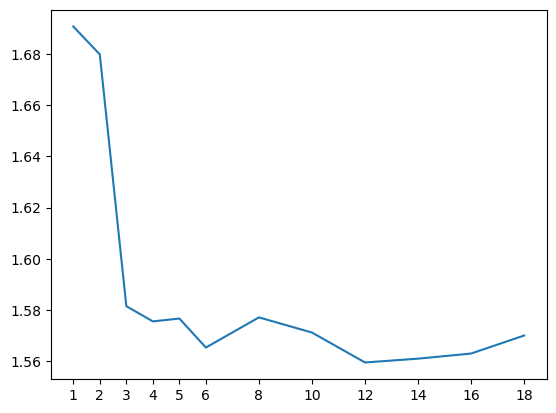

In [92]:
rsme = []
for i in [1,2,3,4,5,6,8,10,12,14, 16,18]:
    models = buildfunctions(X_train_df, y_trainxgb_df, conditionsT1b, n = i, featlist = shap_list_xgb2)
    p = predfunctiontree(X_test_df, models, conditionsT1b, n = i, featlist = shap_list_xgb2)
    mse = mean_squared_error(y_test_df['y_test_pred'], p)
    rsme.append(np.sqrt(mse))

# plot rsme
import matplotlib.pyplot as plt
plt.plot([1,2,3,4,5,6,8,10,12,14, 16,18], rsme)
plt.xticks([1,2,3,4,5,6,8,10,12,14, 16,18])

## Best windspeed split from simple model

In [34]:
# best model

conditions ={}
conditions[1] = {"wind_speed": 1.01}
conditions[2] = {"wind_speed": 2.41}
conditions[3] = {"wind_speed": 3.06}
conditions[4] = {"wind_speed": 5}

models = buildfunctions(X_train_df, y_trainxgb_df, conditions)
p = predfunctiontree(X_test_df, models, conditions)
mse = mean_squared_error(y_testxgb2, p)
eval_bins(p, y_testxgb2, y_test)[0]

Bin: [0, 9e-05]      RMSE: 0.651, Avg. Error: 0.044
Bin: [9e-05, 1]      RMSE: 1.377, Avg. Error: 0.206
Bin: [1, 10]         RMSE: 3.621, Avg. Error: 0.019
Bin: [10, 50]        RMSE: 6.298, Avg. Error: -1.672
Bin: [50, 100]       RMSE: 9.809, Avg. Error: -5.763
Total RSME 1.5156519140139741
Total Avg. Error 0.017166610283462835


[[0, 9e-05],
 0.42400198951275386,
 0.6511543515271582,
 0.21034894343599544,
 0.04374616910826584]

In [95]:
# add wind_speed^4

models_2 = buildfunctions(X_train_pwr, y_trainxgb_df, conditions, n = 19, featlist = X_train_pwr.columns)
p = predfunctiontree(X_test_pwr, models_2, conditions, n = 19, featlist = X_train_pwr.columns)
eval_bins(p, y_testxgb2, y_test)[0]

Bin: [0, 9e-05]      RMSE: 0.621, Avg. Error: 0.045
Bin: [9e-05, 1]      RMSE: 1.168, Avg. Error: 0.206
Bin: [1, 10]         RMSE: 3.654, Avg. Error: -0.071
Bin: [10, 50]        RMSE: 5.955, Avg. Error: -1.885
Bin: [50, 100]       RMSE: 9.107, Avg. Error: -5.697
Total RSME 1.443986019892454
Total Avg. Error 0.009481960838731448


[[0, 9e-05],
 0.38571080277335407,
 0.6210561993679429,
 0.2023238193791076,
 0.044509500111734476]

In [97]:
# reduce n 
n = 6
# add ws_pwr to shaplist
featlist = ["ws_pwr"]+shap_list_xgb2[:n]

models = buildfunctions(X_train_pwr, y_trainxgb_df, conditions, n = n+1, featlist = featlist)
p = predfunctiontree(X_test_pwr, models, conditions, n = n+1, featlist = featlist)
y_test_df["FunctionTree2_n5+pwr"]  = p

mse = mean_squared_error(y_test_df['y_test_pred'], y_test_df['FunctionTree2_n5+pwr'])
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))
eval_bins(y_test_df['FunctionTree2_n5+pwr'], y_test_df['y_test_pred'], y_test_df['percent_houses_damaged'])[0]

MSE:  2.097247256777046
RMSE:  1.448187576516608
Bin: [0, 9e-05]      RMSE: 0.624, Avg. Error: 0.045
Bin: [9e-05, 1]      RMSE: 1.189, Avg. Error: 0.236
Bin: [1, 10]         RMSE: 3.694, Avg. Error: -0.186
Bin: [10, 50]        RMSE: 6.036, Avg. Error: -1.935
Bin: [50, 100]       RMSE: 8.487, Avg. Error: -5.505
Total RSME 1.448187576516608
Total Avg. Error 0.00766689900789836


[[0, 9e-05],
 0.3899987051857303,
 0.6244987631578868,
 0.1939389363722422,
 0.0446817053194391]

## Exhaustive search

In [7]:
r = np.arange(5, 100, 5).round(2).tolist()

for i in r:
    conditions ={}
    #conditions[1] = {"wind_speed": }
    conditions[2] = {"wind_speed": np.percentile(X_train_df['wind_speed'], i)}
    #conditions[3] = {"wind_speed": np.percentile(X_train_df['wind_speed'], i)}
    conditions[4] = {"wind_speed": 5}
    models = buildfunctions(X_train_df, y_trainxgb_df, conditions)
    p = predfunctiontree(X_train_df, models, conditions)
    mse = mean_squared_error(y_trainxgb2, p)
    print("Condition: ", conditions, " RSME: ", np.sqrt(mse))


Condition:  {2: {'wind_speed': -1.1187358365711937}, 4: {'wind_speed': 5}}  RSME:  3.2933765390944814
Condition:  {2: {'wind_speed': -0.9739805623061351}, 4: {'wind_speed': 5}}  RSME:  3.2661637965846992
Condition:  {2: {'wind_speed': -0.8764615939940964}, 4: {'wind_speed': 5}}  RSME:  3.243314128499958
Condition:  {2: {'wind_speed': -0.787827568554495}, 4: {'wind_speed': 5}}  RSME:  3.2232634014473955
Condition:  {2: {'wind_speed': -0.7056763508558689}, 4: {'wind_speed': 5}}  RSME:  3.2035039067519993
Condition:  {2: {'wind_speed': -0.6277290278014406}, 4: {'wind_speed': 5}}  RSME:  3.179062107153525
Condition:  {2: {'wind_speed': -0.5516438215927026}, 4: {'wind_speed': 5}}  RSME:  3.1500353933925402
Condition:  {2: {'wind_speed': -0.47567030928335524}, 4: {'wind_speed': 5}}  RSME:  3.1184269069254262
Condition:  {2: {'wind_speed': -0.39404924026758414}, 4: {'wind_speed': 5}}  RSME:  3.076952310291074
Condition:  {2: {'wind_speed': -0.30672047800650276}, 4: {'wind_speed': 5}}  RSME:  

In [10]:
r = np.arange(95, 100, 0.5).round(2).tolist()

for i in r:
    conditions ={}
    #conditions[1] = {"wind_speed": }
    conditions[2] = {"wind_speed": np.percentile(X_train_df['wind_speed'], i)}
    #conditions[3] = {"wind_speed": np.percentile(X_train_df['wind_speed'], i)}
    conditions[4] = {"wind_speed": 5}
    models = buildfunctions(X_train_df, y_trainxgb_df, conditions)
    p = predfunctiontree(X_train_df, models, conditions)
    mse = mean_squared_error(y_trainxgb2, p)
    print("Condition: ", conditions, " RSME: ", np.sqrt(mse))

# 96th percentile, 2.2414365006859343

Condition:  {2: {'wind_speed': 2.0727974531463653}, 4: {'wind_speed': 5}}  RSME:  1.7840921336956528
Condition:  {2: {'wind_speed': 2.1509205885617804}, 4: {'wind_speed': 5}}  RSME:  1.7619296900154382
Condition:  {2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  1.7491140558247544
Condition:  {2: {'wind_speed': 2.3426785737107143}, 4: {'wind_speed': 5}}  RSME:  1.7536812981575383
Condition:  {2: {'wind_speed': 2.443195022211083}, 4: {'wind_speed': 5}}  RSME:  1.7893430584333034
Condition:  {2: {'wind_speed': 2.54987952851569}, 4: {'wind_speed': 5}}  RSME:  1.8387603067787792
Condition:  {2: {'wind_speed': 2.66624056155341}, 4: {'wind_speed': 5}}  RSME:  1.8851547370824873
Condition:  {2: {'wind_speed': 2.808103184150805}, 4: {'wind_speed': 5}}  RSME:  1.9250094511099545
Condition:  {2: {'wind_speed': 3.063995186365151}, 4: {'wind_speed': 5}}  RSME:  2.116933218049515
Condition:  {2: {'wind_speed': 3.4541588032035317}, 4: {'wind_speed': 5}}  RSME:  2.537998055621111

In [11]:
r = np.arange(70, 96, 5).round(2).tolist()

for i in r:
    conditions ={}
    conditions[1] = {"wind_speed": np.percentile(X_train_df['wind_speed'], i)}
    conditions[2] = {"wind_speed": 2.2414365006859343} #96th percentile
    #conditions[3] = {"wind_speed": np.percentile(X_train_df['wind_speed'], i)}
    conditions[4] = {"wind_speed": 5}
    models = buildfunctions(X_train_df, y_trainxgb_df, conditions)
    p = predfunctiontree(X_train_df, models, conditions)
    mse = mean_squared_error(y_trainxgb2, p)
    print("Condition: ", conditions, " RSME: ", np.sqrt(mse))

# 80th percentile - 0.7296

Condition:  {1: {'wind_speed': 0.23652066443583686}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  1.672903346633447
Condition:  {1: {'wind_speed': 0.44940104046221274}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  1.6596097689625562
Condition:  {1: {'wind_speed': 0.7295963497557665}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  1.6455847262975263
Condition:  {1: {'wind_speed': 1.079901352340773}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  1.6513360582493672
Condition:  {1: {'wind_speed': 1.5399105541229128}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  1.6508529822685065
Condition:  {1: {'wind_speed': 2.0727974531463653}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  1.7352570234857


In [13]:
r = np.arange(77, 83, 0.5).round(2).tolist()

for i in r:
    conditions ={}
    conditions[1] = {"wind_speed": np.percentile(X_train_df['wind_speed'], i)}
    conditions[2] = {"wind_speed": 2.2414365006859343} #96th percentile
    #conditions[3] = {"wind_speed": np.percentile(X_train_df['wind_speed'], i)}
    conditions[4] = {"wind_speed": 5}
    models = buildfunctions(X_train_df, y_trainxgb_df, conditions)
    p = predfunctiontree(X_train_df, models, conditions)
    mse = mean_squared_error(y_trainxgb2, p)
    print("Condition: ", conditions, " RSME: ", np.sqrt(mse))

# 82.5 th percentile - 0.896851435773394

Condition:  {1: {'wind_speed': 0.5579357187910419}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  2.027670257491622
Condition:  {1: {'wind_speed': 0.5863727730351025}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  2.027174310312023
Condition:  {1: {'wind_speed': 0.6147005044613717}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  2.025797618949188
Condition:  {1: {'wind_speed': 0.6424071955313295}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  2.0226048986426295
Condition:  {1: {'wind_speed': 0.6729158907954383}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  2.0213629598744176
Condition:  {1: {'wind_speed': 0.7001529537752899}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  2.018901055050116
Condition:  {1: {'wind_speed': 0.7295963497557665}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  2.017906007609265
Condition:  {1: {'wind_sp

In [15]:
r = np.arange(83, 85, 0.5).round(2).tolist()

for i in r:
    conditions ={}
    conditions[1] = {"wind_speed": np.percentile(X_train_df['wind_speed'], i)}
    conditions[2] = {"wind_speed": 2.2414365006859343} #96th percentile
    #conditions[3] = {"wind_speed": np.percentile(X_train_df['wind_speed'], i)}
    conditions[4] = {"wind_speed": 5}
    models = buildfunctions(X_train_df, y_trainxgb_df, conditions)
    p = predfunctiontree(X_train_df, models, conditions)
    mse = mean_squared_error(y_trainxgb2, p)
    print("Condition: ", conditions, " RSME: ", np.sqrt(mse))

# 82.5 th percentile - 0.896851435773394 - stays

Condition:  {1: {'wind_speed': 0.9305066422327136}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  2.017803645295877
Condition:  {1: {'wind_speed': 0.9677694478499811}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  2.0182841475200024
Condition:  {1: {'wind_speed': 1.004974426831655}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  2.017721883606884
Condition:  {1: {'wind_speed': 1.0412572428782823}, 2: {'wind_speed': 2.2414365006859343}, 4: {'wind_speed': 5}}  RSME:  2.0176551649985774


In [17]:
r = np.arange(96.5, 100, 0.5).round(2).tolist()

for i in r:
    conditions ={}
    conditions[1] = {"wind_speed": 0.896851435773394}
    conditions[2] = {"wind_speed": 2.2414365006859343} #96th percentile
    conditions[3] = {"wind_speed": np.percentile(X_train_df['wind_speed'], i)}
    conditions[4] = {"wind_speed": 5}
    models = buildfunctions(X_train_df, y_trainxgb_df, conditions)
    p = predfunctiontree(X_train_df, models, conditions)
    mse = mean_squared_error(y_trainxgb2, p)
    print("Condition: ", conditions, " RSME: ", np.sqrt(mse))

# 99th , 3.063995186365151

Condition:  {1: {'wind_speed': 0.896851435773394}, 2: {'wind_speed': 2.2414365006859343}, 3: {'wind_speed': 2.3426785737107143}, 4: {'wind_speed': 5}}  RSME:  1.9965372783462032
Condition:  {1: {'wind_speed': 0.896851435773394}, 2: {'wind_speed': 2.2414365006859343}, 3: {'wind_speed': 2.443195022211083}, 4: {'wind_speed': 5}}  RSME:  1.980641551734528
Condition:  {1: {'wind_speed': 0.896851435773394}, 2: {'wind_speed': 2.2414365006859343}, 3: {'wind_speed': 2.54987952851569}, 4: {'wind_speed': 5}}  RSME:  1.96452788159636
Condition:  {1: {'wind_speed': 0.896851435773394}, 2: {'wind_speed': 2.2414365006859343}, 3: {'wind_speed': 2.66624056155341}, 4: {'wind_speed': 5}}  RSME:  1.939160970599408
Condition:  {1: {'wind_speed': 0.896851435773394}, 2: {'wind_speed': 2.2414365006859343}, 3: {'wind_speed': 2.808103184150805}, 4: {'wind_speed': 5}}  RSME:  1.9171182562648617
Condition:  {1: {'wind_speed': 0.896851435773394}, 2: {'wind_speed': 2.2414365006859343}, 3: {'wind_speed': 3.0639951863

In [35]:
conditions ={}
conditions[1] = {"wind_speed": 0.896851435773394} #82.5th percentile
conditions[2] = {"wind_speed": 2.2414365006859343} #96th percentile
conditions[3] = {"wind_speed": 3.063995186365151} # 99th percentile
conditions[4] = {"wind_speed": 5}

models = buildfunctions(X_train_df, y_trainxgb_df, conditions)
p = predfunctiontree(X_test_df, models, conditions)
eval_bins(p, y_testxgb2, y_test)[0]

Bin: [0, 9e-05]      RMSE: 0.645, Avg. Error: 0.046
Bin: [9e-05, 1]      RMSE: 1.396, Avg. Error: 0.214
Bin: [1, 10]         RMSE: 3.608, Avg. Error: 0.074
Bin: [10, 50]        RMSE: 6.215, Avg. Error: -1.668
Bin: [50, 100]       RMSE: 9.992, Avg. Error: -5.871
Total RSME 1.5114222697909228
Total Avg. Error 0.022899481511194034


[[0, 9e-05],
 0.4156601062559751,
 0.6447170745807614,
 0.20115274298359587,
 0.04611547511315019]

In [36]:
# include wind_speed^4
models = buildfunctions(X_train_pwr, y_trainxgb_df, conditions, n = 19, featlist = X_train_pwr.columns)
p = predfunctiontree(X_test_pwr, models, conditions, n = 19, featlist = X_train_pwr.columns)
eval_bins(p, y_testxgb2, y_test)[0]

Bin: [0, 9e-05]      RMSE: 0.651, Avg. Error: 0.045
Bin: [9e-05, 1]      RMSE: 1.368, Avg. Error: 0.208
Bin: [1, 10]         RMSE: 3.550, Avg. Error: 0.083
Bin: [10, 50]        RMSE: 6.169, Avg. Error: -1.616
Bin: [50, 100]       RMSE: 9.343, Avg. Error: -5.504
Total RSME 1.4869064825534841
Total Avg. Error 0.023265192963347083


[[0, 9e-05],
 0.42342231787836204,
 0.650709088516798,
 0.19914974676092473,
 0.044544489270623676]

In [37]:
from featurelists import shap_list

# reduce n 
n = 5
# add ws_pwr to shaplist
featlist = ["ws_pwr"]+shap_list[:n]

models = buildfunctions(X_train_pwr, y_trainxgb_df, conditions, n = n+1, featlist = featlist)
p = predfunctiontree(X_test_pwr, models, conditions, n = n+1, featlist = featlist)

eval_bins(p, y_testxgb2, y_test)[0]

Bin: [0, 9e-05]      RMSE: 0.670, Avg. Error: 0.045
Bin: [9e-05, 1]      RMSE: 1.432, Avg. Error: 0.270
Bin: [1, 10]         RMSE: 3.635, Avg. Error: -0.059
Bin: [10, 50]        RMSE: 6.411, Avg. Error: -1.724
Bin: [50, 100]       RMSE: 9.270, Avg. Error: -5.535
Total RSME 1.5300479084382654
Total Avg. Error 0.023441869822913942


[[0, 9e-05],
 0.44926353886922016,
 0.6702712427586462,
 0.1917801478105894,
 0.045287695607404053]

In [38]:
LRweights = pd.DataFrame(columns = ['Model 1', "Model 2", "Model 3", "Model 4"], index = featlist)
LRweights['Model 1'] = models[1].coef_[0]
LRweights["Model 2"] = models[2].coef_[0]
LRweights["Model 3"] = models[3].coef_[0]
LRweights["Model 4"] = models[4].coef_[0]
# add row with intercepts
LRweights.loc['Intercept'] = [models[1].intercept_[0], models[2].intercept_[0], models[3].intercept_[0], models[4].intercept_[0]]
LRweights.loc['Windspeed Threshold'] = [conditions[1]["wind_speed"], conditions[2]["wind_speed"], conditions[3]["wind_speed"], conditions[4]["wind_speed"]]
LRweights

,Model 1,Model 2,Model 3,Model 4
ws_pwr,0.066867,0.124040,0.739537,0.459843
wind_speed,0.107256,0.663001,-36.586360,-59.022818
track_distance,-0.071474,-0.961429,4.293573,-17.463972
rainfall_max_6h,0.046990,0.516098,3.760528,2.004340
percent_houses_damaged_5years,0.010696,2.121754,1.460091,-0.082448
rainfall_max_24h,0.095326,-0.006572,-1.124246,-8.080037
Intercept,0.176016,-1.016957,73.261075,143.973976
Windspeed Threshold,0.896851,2.241437,3.063995,5.000000
